In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    """
    Класс Discriminator представляет собой сверточную нейронную сеть, используемую для различения изображений.
    
    Аргументы:
    in_channels (int): Количество входных каналов. По умолчанию 4 (1 канал для источника и 3 канала для цели).
    
    Методы:
    __init__(self, in_channels=4): Инициализирует слои дискриминатора.
    forward(self, src, target): Выполняет прямое распространение через сеть. Объединяет входные изображения (src и target) по каналу и пропускает их через модель.
    
    Пример использования:
    discriminator = Discriminator()
    output = discriminator(src_image, target_image)
    """
    def __init__(self, in_channels=5):  # 2 channel source + 3 channels target
        super(Discriminator, self).__init__()
        def discriminator_block(in_channels, out_channels, stride):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),  # No BN in first layer
                nn.LeakyReLU(0.2, inplace=True)
            ]
            return layers

        self.model = nn.Sequential(
            # C64: 4x4 kernel, stride 2, padding 1
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            # C128: 4x4 kernel, stride 2, padding 1
            *discriminator_block(64, 128, stride=2),

            # C256: 4x4 kernel, stride 2, padding 1
            *discriminator_block(128, 256, stride=2),

            # C512: 4x4 kernel, stride 1, padding 1
            *discriminator_block(256, 512, stride=1),

            # C1: 4x4 kernel, stride 1, padding 1
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),

            # Sigmoid activation
            nn.Sigmoid()
        )


    def forward(self, src, target):
        x = torch.cat((src, target), dim=1)
        return self.model(x)

if __name__ == '__main__':
    D = Discriminator()
    x = torch.randn(1, 2, 256, 256)
    target = torch.randn(1, 3, 256, 256)
    print(f'{x.shape} + {target.shape} -> {D(x, target).shape}')  # torch.Size([1, 1, 30, 30])


torch.Size([1, 2, 256, 256]) + torch.Size([1, 3, 256, 256]) -> torch.Size([1, 1, 30, 30])


In [2]:
class UNetGenerator(nn.Module):
    def __init__(self, input_channels=2, output_channels=3):
        super(UNetGenerator, self).__init__()
        
        def encoder_block(in_channels, out_channels, use_bn=True):
            layers = [
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True)
            ]
            if use_bn:
                layers.append(nn.BatchNorm2d(out_channels))
            return nn.Sequential(*layers)

        def decoder_block(in_channels, out_channels, dropout=0):
            layers = [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(out_channels)
            ]
            if dropout != 0:
                layers.append(nn.Dropout(dropout))
            return nn.Sequential(*layers)

        def bottleneck_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1),
                nn.ReLU(inplace=True),
            )

        # Encoder
        self.enc1 = encoder_block(input_channels, 64, use_bn=False)
        self.enc2 = encoder_block(64, 128)
        self.enc3 = encoder_block(128, 256)
        self.enc4 = encoder_block(256, 512)
        self.enc5 = encoder_block(512, 512)
        self.enc6 = encoder_block(512, 512)
        self.enc7 = encoder_block(512, 512)

        self.bottleneck = bottleneck_block(512, 512)

        # Decoder
        self.dec1 = decoder_block(512, 512, dropout=0.5)
        self.dec2 = decoder_block(1024, 512, dropout=0.5)
        self.dec3 = decoder_block(1024, 512, dropout=0.5)
        self.dec4 = decoder_block(1024, 512)
        self.dec5 = decoder_block(1024, 256)
        self.dec6 = decoder_block(512, 128)
        self.dec7 = decoder_block(256, 64)
        self.final = nn.ConvTranspose2d(128, output_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)

        b = self.bottleneck(e7)

        # Decoder + Skip connections
        d1 = self.dec1(b)
        d2 = self.dec2(torch.cat([d1, e7], dim=1))
        d3 = self.dec3(torch.cat([d2, e6], dim=1))
        d4 = self.dec4(torch.cat([d3, e5], dim=1))
        d5 = self.dec5(torch.cat([d4, e4], dim=1))
        d6 = self.dec6(torch.cat([d5, e3], dim=1))
        d7 = self.dec7(torch.cat([d6, e2], dim=1))
        return torch.tanh(self.final(torch.cat([d7, e1], dim=1)))

if __name__ == '__main__':
    G = UNetGenerator()
    x = torch.randn(1, 2, 256, 256)
    print(f'{x.shape} -> {G(x).shape}')  # torch.Size([1, 3, 256, 256])


torch.Size([1, 2, 256, 256]) -> torch.Size([1, 3, 256, 256])


In [3]:
class Pix2PixGAN:
    def __init__(self, device):
        self.device = device
        self.generator = UNetGenerator().to(self.device)
        self.discriminator = Discriminator().to(self.device)

        self.optimizer_G = torch.optim.AdamW(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.AdamW(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion_GAN = nn.BCEWithLogitsLoss()
        self.criterion_L1 = nn.L1Loss()

    def train_step(self, real_A, real_B):
        real_A, real_B = real_A.to(self.device), real_B.to(self.device)

        # Train Discriminator
        self.optimizer_D.zero_grad()
        fake_B = self.generator(real_A)

        # Получаем выходные данные дискриминатора
        output_real = self.discriminator(real_A, real_B)
        output_fake = self.discriminator(real_A, fake_B.detach())

        # Создаем целевые метки того же размера, что и выходные данные дискриминатора
        target_real = torch.ones_like(output_real)
        target_fake = torch.zeros_like(output_fake)

        # Вычисляем потери
        loss_D_real = self.criterion_GAN(output_real, target_real)
        loss_D_fake = self.criterion_GAN(output_fake, target_fake)
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        self.optimizer_D.step()

        # Train Generator
        self.optimizer_G.zero_grad()
        loss_G_GAN = self.criterion_GAN(self.discriminator(real_A, fake_B), torch.ones_like(output_real))
        loss_G_L1 = self.criterion_L1(fake_B, real_B) * 100
        loss_G = loss_G_GAN + loss_G_L1
        loss_G.backward()
        self.optimizer_G.step()

        return loss_D.item(), loss_G.item()


In [4]:
from utils.helpers import *
from utils.loss_tracker import save_losses

In [5]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
print(f'Using {device}')
torch.cuda.empty_cache() if torch.cuda.is_available() else torch.mps.empty_cache() if torch.mps.is_available() else None

model = Pix2PixGAN(device)
epochs = 500
g_loss = []
d_loss = []

model.generator.load_state_dict(torch.load("saved_models/best_generator_pix2pix_491.pth", map_location=device))
model.discriminator.load_state_dict(torch.load("saved_models/best_discriminator_pix2pix_491.pth", map_location=device))

for epoch in range(491, epochs):
    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False) as pbar:
        for i, (real_A, real_B) in enumerate(pbar):
            loss_D, loss_G = model.train_step(real_A, real_B)
            pbar.set_postfix({"Loss D": loss_D, "Loss G": loss_G})
        g_loss.append(loss_G)
        d_loss.append(loss_D)

        if (epoch + 1) % 50 == 0:
            torch.save(model.generator.state_dict(), os.path.join(os.getcwd(), f"saved_models/best_generator_pix2pix_{epoch+1}.pth"))
            torch.save(model.discriminator.state_dict(), os.path.join(os.getcwd(), f"saved_models/best_discriminator_pix2pix_{epoch+1}.pth"))
            save_losses(g_loss, d_loss)


Using cuda


C:\Users\tiruu\AppData\Local\Temp\ipykernel_16528\556182315.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.generator.load_state_dict(torch.load("saved_models/bes

Epoch 492/500:   0%|          | 0/91 [00:00<?, ?it/s]

KeyboardInterrupt: 

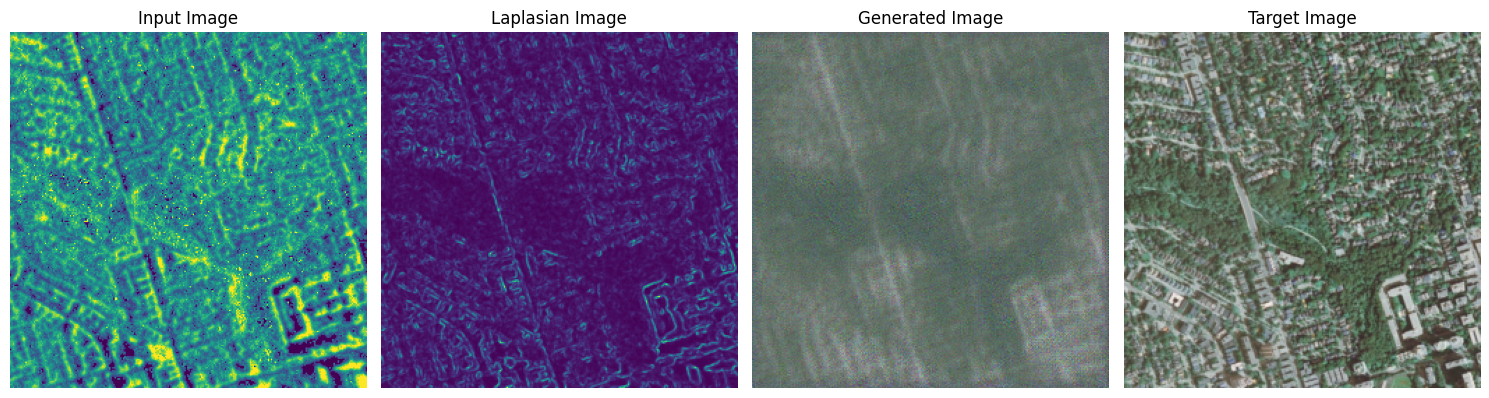

In [7]:
with torch.no_grad():
    real_A = real_A.to(device)
    fake_B = model.generator(real_A)
    # Convert tensors to images
    real_A_img = real_A[0].cpu().numpy().transpose(1, 2, 0)
    fake_B_img = fake_B[0].cpu().numpy().transpose(1, 2, 0)
    real_B_img = real_B[0].cpu().numpy().transpose(1, 2, 0)
    
    # Plot images
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    axes[0].imshow((real_A_img[:, :, 0] * 0.5 + 0.5))
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    axes[1].imshow((real_A_img[:, :, 1] * 0.5 + 0.5))
    axes[1].set_title('Laplasian Image')
    axes[1].axis('off')

    axes[2].imshow((fake_B_img * 0.5 + 0.5))
    axes[2].set_title('Generated Image')
    axes[2].axis('off')

    axes[3].imshow((real_B_img * 0.5 + 0.5))
    axes[3].set_title('Target Image')
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()